# A Gradient Boosted Tree Model for the Adult Dataset

## Introduction

This example introduces the reader to the fitting and evaluation of gradient boosted tree models. We consider a binary classification task into two income brackets  (less than or greater than  \$50, 000), given attributes such as capital gains and losses, marital status, age, occupation, etc..

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from alibi.datasets import fetch_adult
from copy import deepcopy
from functools import partial
from itertools import chain, product
from scipy.special import expit
invlogit=expit
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing the features, targets, feature names and a mapping of categorical variables to numbers.

In [36]:
adult = fetch_adult()
adult.keys()

data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use the utility function `gen_category_map` imported from `alibi.utils.data`  to create the category map.

In [37]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

### Create feature transformation pipeline and preprocess data

Unlike in a previous [example](kernel_shap_adult_lr.ipynb), the categorical variables are not encoded. For linear models such as logistic regression, using an encoding of the variable that assigns a unique integer to a category will affect the coefficient estimates as the model will learn patterns based on the ordering of the input, which is incorrect. In contrast, by encoding the into a sequence of binary variables, the model can learn which encoded dimensions are relevant for predicting a given target but cannot represent non-linear relations between the categories and targets. 

On the other hand, decision trees can naturally handle both data types simultaneously; a categorical feature can be used for splitting a node multiple times. So, hypothetically speaking, if the categorical variable `var` has `4` levels, encoded `0-3` and level `2` correlates well with a particular outcome, then a decision path could contain the splits `var < 3` and `var > 1` if this pattern generalises in the data and thus splitting according to these criteria reduce the splits' impurity. 

In general, we note that for a categorical variable with $q$ levels there are $2^{q-1}-1$ possible partitions into two groups, and for large $q$ finding an optimal split is intractable. However, for binary classification problems an optimal split can be found efficiently (see references in [[1]](#References)). As $q$ increases, the number of potential splits to choose from increases, so it is more likely that a split that fits the data is found. For large $q$ this can lead to overfitting, so variables with large number of categories can potentially harm model performance.

The interested reader is referred to consult these blog posts ([first](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/), [second](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)), which demonstrate of the pitfalls of encoding categorical data as one-hot when using tree-based models. `sklearn` expects that the categorical data is encoded, and this approach should be followed when working with this library.

<a id='source_4'></a>

## Model optimisation
<a id='optimisation'></a>

`xgboost` wraps arrays using  `DMatrix` objects, optimised for both memory efficiency and training speed.

In [7]:
def wrap(arr):
    return np.ascontiguousarray(arr)

dtrain = xgb.DMatrix(
    wrap(X_train), 
    label=wrap(y_train), 
    feature_names=feature_names, 
)

dtest = xgb.DMatrix(wrap(X_test), label=wrap(y_test), feature_names=feature_names)

`xgboost` defines three classes of parameters that need to be configured in order to train and/or optimise a model:

* general parameters: high level settings such as the type of boosting model

* learning parameters: these are parameters that control the boosting process (model hyperparameters)

* learning task parameters: define the optimisation objective and the metric on which the validation performance is measured

In [8]:
learning_params = {}
booster_params = {}
general_params = {}
params = {}

This is a binary classification problem, optimised with binary cross-entropy as an objective, defined as:
<a id='f_1'></a>

$$
J (y_i, \hat{y}_i) = -\frac{1}{N} \sum_{i=1}^N [y_i \log(1 + e^{- \hat{y}_i}) + (1 - y_i) \log (1 + e^{\hat{y}_i})]
$$

where $y_i$ is the true label for the $i$th observation and $\hat{y}_i$ is the decision score (logit) <sup>[(1)](#Footnotes) </sup> of the positive class (whose members' income exceeds \$50, 000). Setting the objective to `binary:logitraw` means the call to the `predict` method will output $\hat{y}_i$. 

<a id='f_1'></a>

In [ ]:
learning_params.update({
    'objective':'binary:logitraw',
    'seed': 42,
    'eval_metric': ['auc', 'logloss'] # metrics computed for specified dataset
})

The [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) will be used as a target for early stopping during hyperparameter optimisation . Using this metric as opposed to, e.g., accuracy helps deal with the imbalanced data since this metric balances the true positive rate and the false positive rate. However, it should be noted that AUC is an _aggregate_ performance measure since it is derived by matching predicted labels with ground truths across models with different output thresholds. In practice, however, only one such model is selected. Thus, a higher AUC just reflects that on average, the ensemble performs better. However, whether the classifier selected according to this metric is optimal depends on the threshold chosen for converting the predicted probabilities to class labels.

Additionally, the weights of the positive are scaled to reflect the class imbalance. A common setting is to scale the positive class by the ratio of the negative to positive examples (approximately 3 for this dataset). Since this is a heuristic approach, this parameter will be cross-validated.


The first parameters optimised are:

* `max_depth`: the maximum depth of any tree added to the ensemble. Deeper trees are more accurate (on training data) since they represent more specific rules

* `min_child_weight`: child nodes are required to have a total weight above this threshold for a split to occur. For a node $L$, this weight is computed according to 

$$
H_L = \sum_{i}w_i  \frac{\partial^2 J (y_i, \hat{y}_{i,{t-1}})}{\partial {\hat{y}_{i,t-1}}^2}
$$

where the summation of Hessians is over all examples $i$ split at the node, and the subscript $t-1$ indicates that the derivative is with respect to the output evaluated at the previous round in the boosting [process](https://xgboost.readthedocs.io/en/latest/tutorials/model.html). In this example, the weight $w_i$ depends on the class and is controlled through the `scale_pos_weight` argument. The second derivative above is given by

$$
\frac{2 e^{\hat{y}_i}}{{(1 + e^{\hat{y}_i})}^2},
$$

whose variation is depicted in Figure 1.

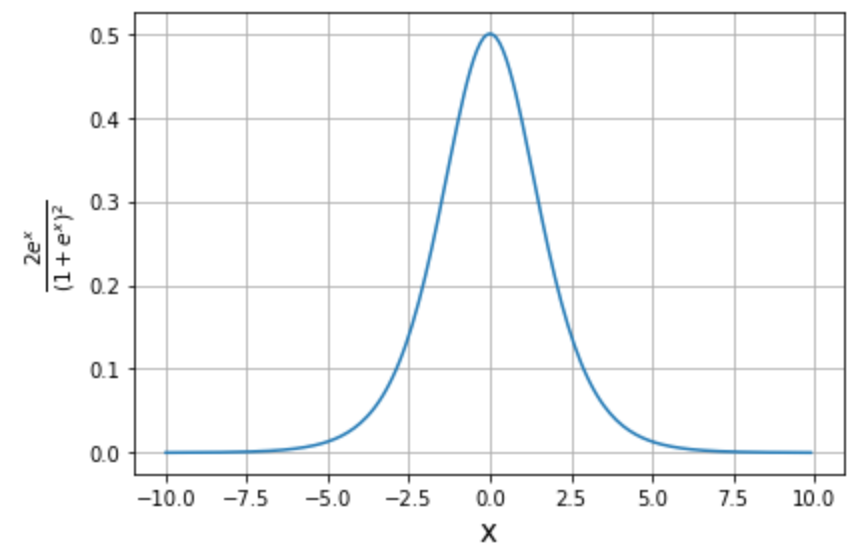

Figure 1 shows that when the classifier assigns a high positive or a low negative score, the contribution of data point $i$ to the child weight is very small. Therefore, setting a very small value for `min_child_weight` parameter can result in overfitting since the splitting process will make splits in order to ensure the instances in a leaf are correctly classified at the expense of finding more parsimonious rules that generalise well.

* `scale_pos_weight`: a scaling factor applied to the positive class to deal with class imbalance

* `gamma`: is a parameter that controls the minimum gain that has to be attained in order for a split to be made

To understand `gamma`, recall that the _gain_ of making a particular split is defined as function of the _structure scores_ of the left (L) and right (R) child nodes and the structure score of the parent as 

$$
gain = \frac{1}{2}\left[\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{{(G_L+G_R)}^2}{H_L + H_R + \lambda}  \right] - \gamma
$$

where $\lambda$ is a regularisation hyperparameter shrinking the model output, $H_L$ is defined above and $G_L$ is given by

$$
G_L = \sum_{i}w_i  \frac{\partial J (y_i, \hat{y}_{i,{t-1}})}{\partial {\hat{y}_{i,t-1}}}
$$

and $i$ sums over the points that flow through the node $L$. Note that these structure scores represent minimisers of the objective (which is simply a quadratic in the leaf value). To make a split, the gain should exceed $\gamma$.


The _learning rate_ (`eta`) is fixed. This parameter is the fraction of the output score a member of the ensemble contributes to the decision score. Lower values yield larger ensembles.

In [1]:
def tune_params(dtrain, base_params,  param_dict, maximise=True, prev_optimum=None, **kwargs):
    """
        Given a training set `dtrain`, a dictionary of parameters to be optimised `param_dict` and 
        all the other learning and booster parameters (`base_param`), this function runs an 
        exhaustive grid search over the tuning parameters.
        
        NB: Specifying `prev_optimum` allows one to tune parameters in stages. maximise should indicate
        if the evaluation metric should be maximised during CV.
    """

    def _statistic(maximise, argument=False):
        if maximise:
            if argument:
                return np.argmax
            return np.max
        if argument:
            return np.argmin
        return np.min
    
    
    def _compare(optimum, val, maximise=True):
        
        eps=1e-4
        
        if maximise:
            if val > optimum + eps:
                return True
            return False
        if val < optimum - eps:
            return True
        return False
    
    statistic = partial(_statistic, maximise)
    compare = partial(_compare, maximise=maximise)
    metrics = kwargs.get("metrics")
    if isinstance(metrics, list):
        opt_metric = metrics[-1]
    else:
        opt_metric = metrics

    print(f"CV with params: {list(param_dict.keys())}")
    print(f"Tracked metrics: {metrics}")
    print(f"Cross-validating on: {opt_metric}")
    
    if prev_optimum:
        optimum = prev_optimum
    else:    
        optimum = -float("Inf") if maximise else float("Inf")
    
    params = deepcopy(base_params)
    pars, pars_val = list(param_dict.keys()), list(param_dict.values())
    combinations = list(product(*pars_val))
    best_combination = {}
    
    # run grid search
    for combination in tqdm(combinations):
        for p_name, p_val in zip(pars, combination):
            params[p_name] = p_val
        cv_results = xgb.cv(
            params,
            dtrain,
            **kwargs,
        )
        mean = statistic()(cv_results[f'test-{opt_metric}-mean'])
        boost_rounds = statistic(argument=True)(cv_results[f'test-{opt_metric}-mean'])    
        improved = compare(optimum, mean)
        if improved:
            optimum = mean
            for name, val in zip(pars, combination):
                best_combination[name]=val
            print(f"{opt_metric} mean value: {mean} at {boost_rounds} rounds")
            msg = 'Best params:' + '\n{}: {}'*len(pars)
            print(msg.format(*list(chain(*best_combination.items()))))
        
    return optimum, best_combination, boost_rounds

In [18]:
booster_params.update({'eta': 0.1})

tuning_params={
        'scale_pos_weight': [2, 3, 4, 5],
        'min_child_weight': [0.1, 0.5, 1.0, 2.0, 5.0],
        'max_depth': [3, 4, 5],
        'gamma': [0.01, 0.05, 0.08, 0.1, 0.2]
}

All parameters apart from the ones tuned are included in `params`. The cross-validation process is controlled through `cv_opts`.

In [19]:
params.update(general_params)
params.update(learning_params)
params.update(booster_params)

cv_opts = {
    'num_boost_round': 1000,
    'nfold': 5, 
    'stratified': True,
    'metrics': ['logloss', 'aucpr', 'auc'],  # can alternatively perform early stopping on log-loss or aucpr
    'early_stopping_rounds': 20,
    'seed': 42,
}

Optimise `scale_pos_weight`, `min_child_weight`, `max_depth` and `gamma`. Note that this section is **long running** since it conducts an extensive grid search. 

In [ ]:
optimum, best_params, boost_rounds = tune_params(dtrain, 
                                                 params, 
                                                 tuning_params, 
                                                 maximise=True, 
                                                 **cv_opts
                                                )

if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})

In [ ]:
params

Further optimisation is possible by adjusting the following parameters:

* `subsample`: this is the ratio of the total training examples that will be used for training during each boosting round

* `colsamplebytree`: this is the ratio of the features used to fit an ensemble member during a boosting round

Training on uniformly chosen data subsamples with uniformly chosen subsets of features promotes noise robustness. 

In [ ]:
tuning_params = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsamplebytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

optimum, best_params, boost_rounds = tune_params(dtrain, 
                                                 params, 
                                                 tuning_params, 
                                                 maximise=True, 
                                                 prev_optimum=optimum,
                                                 **cv_opts
                                                )

None of the stated configuration resulted in an improvement of the AUC, which could be a consequence of the fact that:

* the parameters selected in the previous round provide strong model regularisation; in particular, the maximum tree depth for any ensemble member is 3, which means only a subset of features are used anyway to perform the splits in any given tree. Further subsampling may thus not be effective since the subsampling is already implicit in the chosen tree structure

* the AUC is insensitive to small model changes since it measures how the proportion of false positives changes as the number of false negatives changes across a range of models. The confidence of the models does not feature in this measure (since a highly confident classifier and one that predicts probabilities near the decision threshold will have identical AUC)


In [ ]:
if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})

In [ ]:
params

To prevent overfitting, a regulariser $\Omega(f_t)$ with the form 

$$
\Omega(f_t) = \gamma T + \frac{\lambda}{2} \sum_{j=1}^T s_{j,t}^2
$$

is added to the objective function at every boosting round $t$. Above $T$ is the total number of leaves and $s_{j,t}$ is the score of the $j$th leaf at round $t$. For the binary logistic objective, a higher $\lambda$ penalises confident predictions (shrinks the scores). 

By default $\lambda = 1$. Since subsampling data and features did not improve the performance, we explore with relaxing regularisation in order to adjust the model regularisation.

In [ ]:
tuning_params = {
    'lambda': [0.01, 0.1, 0.5, 0.9, 0.95, 1, 2, 5, 10]
}

optimum, best_params, boost_rounds = tune_params(dtrain, 
                                                 params, 
                                                 tuning_params, 
                                                 maximise=True, 
                                                 prev_optimum=optimum,
                                                 **cv_opts)

if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})

## Model training
<a id='training'></a>

The model will now be trained with the following parameters (skip the `param` update if you ran the optimisation section):

In [27]:
learning_params = {
    'objective':'binary:logitraw',
    'seed': 42,
    'eval_metric': ['auc', 'logloss'] # metrics computed for specified dataset
}


params = { 
    'scale_pos_weight': 2,
    'min_child_weight': 0.1,
    'max_depth': 3,
    'gamma': 0.01, 
    'boost_rounds': 541,
}

params.update(learning_params)

In [ ]:
if 'boost_rounds' in params:
    boost_rounds = params.pop('boost_rounds')

model = xgb.train(
    params,
    dtrain,
    num_boost_round=boost_rounds,
    evals=[(dtrain, "Train"), (dtest, "Test")],
)

In [44]:
model.save_model('adult_xgb.mdl')

## Model assessment

The confusion matrix is used to quantify the model performance below.

In [ ]:
def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """
    
    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()


def predict(xgb_model, dataset, proba=False, threshold=0.5):
    """
    Predicts labels given a xgboost model that outputs raw logits. 
    """
    
    y_pred = model.predict(dataset)  # raw logits are predicted
    y_pred_proba = invlogit(y_pred) 
    if proba:
        return y_pred_proba
    y_pred_class = np.zeros_like(y_pred)
    y_pred_class[y_pred_proba >= threshold] = 1  # assign a label 
    
    return y_pred_class
    

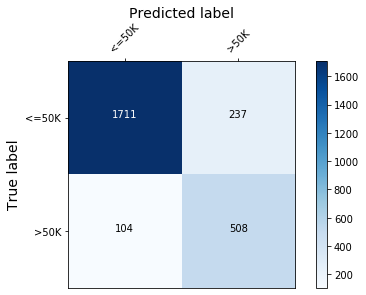

Train accuracy:  87.75  %.
Test  accuracy:  86.6797%.


In [40]:
y_pred_train = predict(model, dtrain)
y_pred_test = predict(model, dtest)

plot_conf_matrix(y_test, y_pred_test, target_names)

print(f'Train accuracy:  {round(100*accuracy_score(y_train, y_pred_train), 4)}  %.')
print(f'Test  accuracy:  {round(100*accuracy_score(y_test, y_pred_test), 4)}%.')

## Footnotes

<a id='Footnotes'></a>

[(1)](#f_1): One can derive the stated formula by noting that the probability of the positive class is $p_i = 1/( 1 + \exp^{-\hat{y}_i})$ and taking its logarithm.

## References

<a id='References'></a>


[[1]](#source_4) Hastie, T., Tibshirani, R. and Friedman, J., 2009. The elements of statistical learning: data mining, inference, and prediction, p. 310, Springer Science & Business Media.
